<a href="https://colab.research.google.com/github/majiddaeinejad/quera-ai-bootcamp-divar/blob/statistical_analysis/Question_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setup** cell

In [62]:
!pip install arabic-reshaper python-bidi jdatetime utm --quiet

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import arabic_reshaper
from bidi.algorithm import get_display
import jdatetime

import geopandas as gpd
from shapely.geometry import Polygon
import folium
from branca.colormap import StepColormap


rcParams['font.family'] = 'DejaVu Sans'

def fa_label(text):
    return get_display(arabic_reshaper.reshape(text))

Load data

In [63]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)


file_path = '/content/drive/MyDrive/Colab Notebooks/Divar.csv'


df = pd.read_csv(file_path , encoding='utf-8')

Mounted at /content/drive


/tmp/ipython-input-1578516001.py:9: DtypeWarning: Columns (11,27,29,53) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path , encoding='utf-8')


ماتریس هم‌بستگی را برای مبلغ قیمت، متراژ زمین، زیربنا، ظرفیت نفرات، تعداد اتاق‌ها و طول و عرض جغرافیایی رسم نمایید.

Miss Values

In [64]:
cols = [
    "price_value",
    "land_size",
    "building_size",
    "regular_person_capacity",
    "rooms_count",
    "location_latitude",
    "location_longitude"
]


nan_count = df[cols].isna().sum()


nan_percent = (nan_count / len(df) * 100).round(2)


result = pd.DataFrame({
    'nan_count': nan_count,
    'nan_percent': nan_percent
})

print(result)

                         nan_count  nan_percent
price_value                 431654        43.17
land_size                   813604        81.36
building_size                19606         1.96
regular_person_capacity     970130        97.01
rooms_count                 154101        15.41
location_latitude           344392        34.44
location_longitude          344392        34.44


In [65]:
print(df[cols].describe())


        price_value     land_size  building_size  regular_person_capacity  \
count  5.683460e+05  1.863960e+05   9.803940e+05             29870.000000   
mean   1.736537e+10  4.165480e+03   4.440648e+03                 6.557650   
std    5.878739e+11  1.218927e+05   1.367118e+05                 7.698655   
min    0.000000e+00  1.000000e+00   1.000000e+00                 1.000000   
25%    1.400000e+09  1.100000e+02   7.500000e+01                 3.000000   
50%    2.840000e+09  1.950000e+02   1.030000e+02                 4.000000   
75%    5.900000e+09  2.800000e+02   1.650000e+02                 7.000000   
max    1.000000e+14  1.000000e+07   1.000000e+07                50.000000   

       location_latitude  location_longitude  
count      655608.000000       655608.000000  
mean           34.982108           51.629743  
std             2.379169            3.160920  
min            23.626478           40.162369  
25%            34.553551           50.677175  
50%            35.723312

city_neighborhood

In [66]:
df['neighborhood_slug'] = df['neighborhood_slug'].fillna('')

df['city_neighborhood'] = df['city_slug'] + df['neighborhood_slug']

print(df[['city_slug', 'neighborhood_slug', 'city_neighborhood']].head())



  city_slug neighborhood_slug city_neighborhood
0     karaj         mehrshahr    karajmehrshahr
1    tehran           gholhak     tehrangholhak
2    tehran             tohid       tehrantohid
3    tehran          elahiyeh    tehranelahiyeh
4   mashhad          emamreza   mashhademamreza


price_value

In [67]:
zero = (df['price_value'] == 0).sum()
zero

np.int64(1902)

In [68]:
df = df[~df['price_value'].isna()]
df = df[df['price_value'] != 0]

print((df['price_value'].isna()).sum())
print((df['price_value'] == 0).sum())




0
0


land_size

In [69]:
group_temp = (
    df.groupby('building_size')['land_size']
      .median()
      .ffill()
      .reset_index()
      .rename(columns={'land_size': 'med'})
)


df_temp = df[['building_size']].merge(group_temp, on='building_size', how='left')

In [70]:
df['land_size'] = df['land_size'].fillna(df_temp['med'])
df['land_size'] = df['land_size'].fillna(df['building_size'])

In [71]:
print(df['land_size'].isna().sum())


585


building_size

In [72]:
group_temp = df.groupby('city_neighborhood')['building_size'].median().reset_index()
group_temp = group_temp.rename(columns={'building_size': 'med'})

df_temp = df[['city_neighborhood']].merge(group_temp, on='city_neighborhood', how='left')

In [73]:
df['building_size'] = df['building_size'].fillna(df_temp['med'])

In [74]:
print(df['building_size'].isna().sum())

582


 location_latitude , location_longitude

In [75]:
print(df[['location_latitude', 'location_longitude']].isna().sum())

location_latitude     195529
location_longitude    195529
dtype: int64


In [76]:
neigh_mean = df.groupby('neighborhood_slug')[['location_latitude', 'location_longitude']].transform('mean')
df['location_latitude'] = df['location_latitude'].fillna(neigh_mean['location_latitude'])
df['location_longitude'] = df['location_longitude'].fillna(neigh_mean['location_longitude'])


city_mean = df.groupby('city_slug')[['location_latitude', 'location_longitude']].transform('mean')
df['location_latitude'] = df['location_latitude'].fillna(city_mean['location_latitude'])
df['location_longitude'] = df['location_longitude'].fillna(city_mean['location_longitude'])

In [77]:
print(df[['location_latitude', 'location_longitude']].isna().sum())

location_latitude     0
location_longitude    0
dtype: int64


In [78]:
df = df.dropna(subset=['location_latitude', 'location_longitude'])

In [79]:
print(df[['location_latitude', 'location_longitude']].isna().sum())

location_latitude     0
location_longitude    0
dtype: int64


room count

In [80]:
df['rooms_count'].value_counts(dropna=False)


,count
rooms_count,
دو,235957
NaN,111457
یک,89218
سه,83953
بدون اتاق,23897
چهار,14029
پنج یا بیشتر,7933


In [81]:
mapping = {
    "یک": 1,
    "دو": 2,
    "سه": 3,
    "چهار": 4,
    "پنج یا بیشتر": 5,
    "بدون اتاق": 0
}

df['rooms_count'] = df['rooms_count'].replace(mapping)

/tmp/ipython-input-1628126833.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['rooms_count'] = df['rooms_count'].replace(mapping)


In [82]:
df['rooms_count'].value_counts(dropna=False)


,count
rooms_count,
2.0,235957
NaN,111457
1.0,89218
3.0,83953
0.0,23897
4.0,14029
5.0,7933


In [83]:
group_temp = (
    df.groupby('building_size')['rooms_count']
      .median()
      .reset_index()
      .rename(columns={'rooms_count': 'med'})
)

df['rooms_count'] = df['rooms_count'].fillna(
    df[['building_size']].merge(group_temp, on='building_size')['med']
)

df['rooms_count'] = df['rooms_count'].fillna(df['rooms_count'].median())


df['rooms_count'] = df['rooms_count'].round().astype(int)




In [84]:
print(df['rooms_count'].isna().sum())


0


In [85]:
nan_count = df[cols].isna().sum()


nan_percent = (nan_count / len(df) * 100).round(2)


result = pd.DataFrame({
    'nan_count': nan_count,
    'nan_percent': nan_percent
})

print(result)

                         nan_count  nan_percent
price_value                      0          0.0
land_size                      585          0.1
building_size                  582          0.1
regular_person_capacity     566444        100.0
rooms_count                      0          0.0
location_latitude                0          0.0
location_longitude               0          0.0


/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


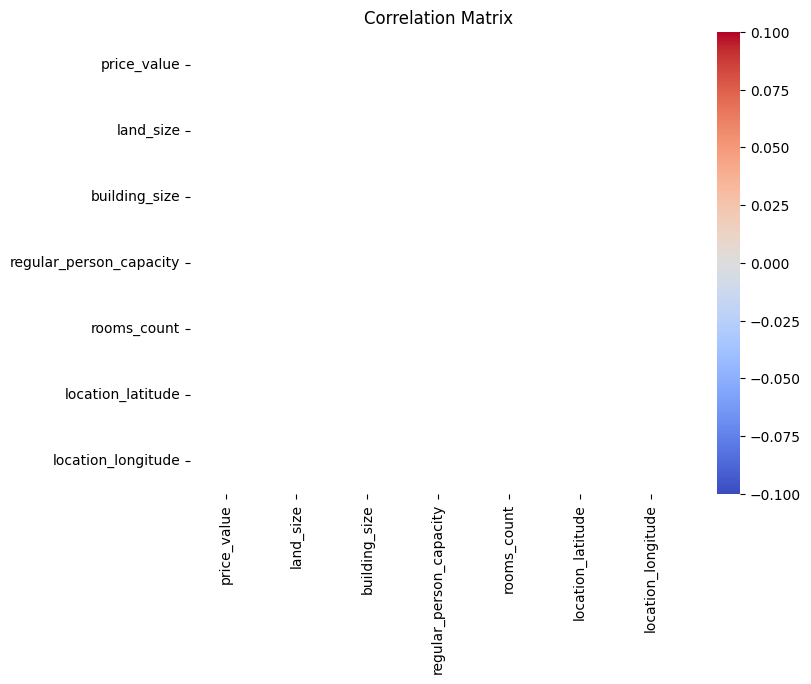

In [86]:
df_clean = df[cols].dropna()

corr_matrix = df_clean.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

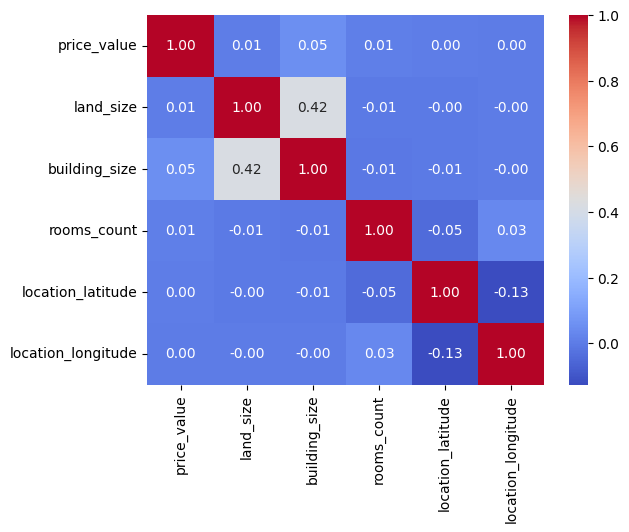

In [87]:
df = df.drop(columns=['regular_person_capacity'])

cols2 = [
    'price_value',
    'land_size',
    'building_size',
    'rooms_count',
    'location_latitude',
    'location_longitude'
]

df_clean = df[cols2].dropna()

sns.heatmap(df_clean.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()


